# Load data

In [2]:
import pandas as pd

In [3]:
dataset = pd.read_csv('heart.csv')

# Analysis

In [5]:
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [7]:
dataset.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [35]:
# Need to have all the values in float64
import numpy as np

dataset = dataset.astype(np.float64)

In [12]:
import matplotlib.pyplot as plt

% matplotlib inline

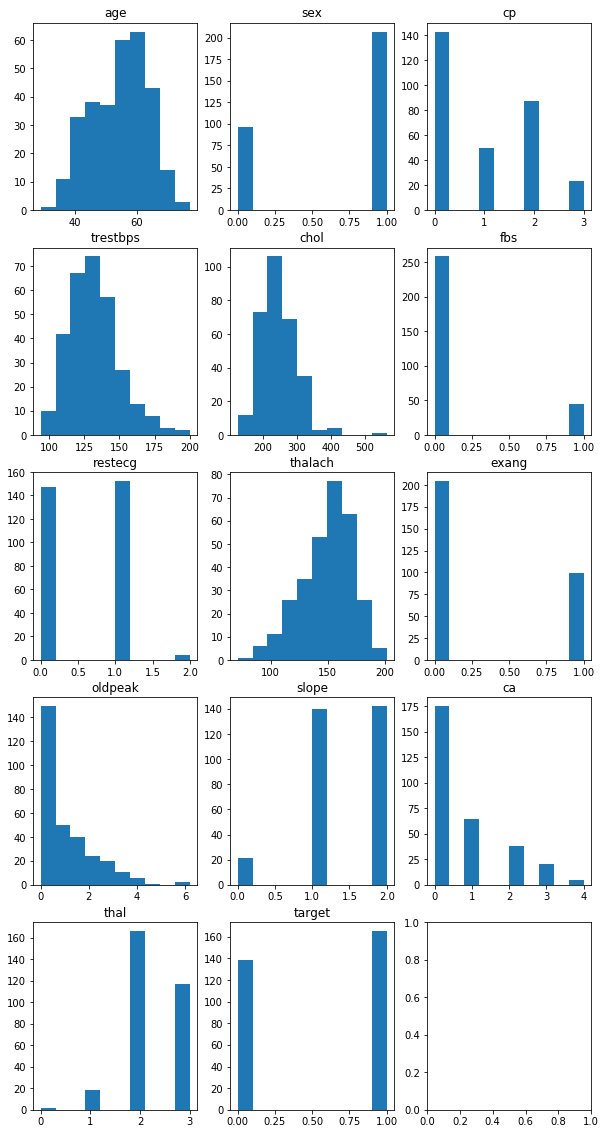

In [34]:
fig, ax = plt.subplots(5, 3)

for i, column_name in enumerate(dataset.columns):
    a, b = i // 3, i % 3
    
    dat = dataset[column_name]
    
    ax[a, b].hist(dat)
    ax[a, b].set_title(column_name)

fig.set_size_inches(10, 20)

plt.show()

# Split into train / test

In [46]:
from sklearn.model_selection import train_test_split

random_state = 12345

x_train, x_test, y_train, y_test = train_test_split(
    dataset.values[:, :-1], dataset.values[:, -1],
    random_state=random_state)

# Create Model Pipeline

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
clf = LogisticRegression()

pipeline = make_pipeline(scaler, clf)

In [39]:
# Look at the pipeline params just to make sure that I have the right names for things

pipeline.get_params()

{'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'ovr',
 'logisticregression__n_jobs': 1,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'liblinear',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False,
 'memory': None,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'standardscaler__copy': True,
 'standardscaler__with_mean': T

# Do K-fold CV

In [84]:
hp_grid = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__random_state': [random_state],
    'logisticregression__C': np.linspace(0.1, 3.0, 100)
}

num_folds = 10

In [95]:
valid_index

(array([ 23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
         36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
         75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
        153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
        179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
        192, 193, 194, 195, 196, 197, 198, 199, 200

In [94]:
x_train[valid_index]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (204,) (23,) 

In [104]:
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import log_loss

k_fold = KFold(num_folds)
grid = ParameterGrid(hp_grid)

rows = list()

for j, params in enumerate(grid):
    
    pipeline.set_params(**params)
    
    print('Hyper Parameters: {}/{}'.format(j, len(grid)))
    
    y_hat = np.zeros_like(y_train)

    for k, (train_index, valid_index) in enumerate(k_fold.split(x_train, y_train)):
        print('  Fold: {}/{}'.format(k, num_folds))
    
        x_train_this_fold = x_train[train_index]
        x_valid = x_train[valid_index]
        y_train_this_fold = y_train[train_index]
        
        pipeline.fit(x_train_this_fold, y_train_this_fold)
        
        y_hat[valid_index] = pipeline.predict(x_valid)
    
    loss = log_loss(y_train, y_hat)
    
    new_row = {'loss': loss, **params}
    rows.append(new_row)

Hyper Parameters: 0/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 1/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 2/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 3/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 4/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 5/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 6/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10


  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 65/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 66/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 67/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 68/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 69/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 70/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper

  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 128/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 129/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 130/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 131/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 132/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 133/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10

  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 188/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 189/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 190/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 191/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 192/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10
  Fold: 7/10
  Fold: 8/10
  Fold: 9/10
Hyper Parameters: 193/200
  Fold: 0/10
  Fold: 1/10
  Fold: 2/10
  Fold: 3/10
  Fold: 4/10
  Fold: 5/10
  Fold: 6/10

# Select Best HPs

In [105]:
results = pd.DataFrame(rows)

results.sort_values('loss')

,logisticregression__C,logisticregression__penalty,logisticregression__random_state,loss
14,0.305051,l1,12345,5.325439
16,0.334343,l1,12345,5.477596
6,0.187879,l1,12345,5.477596
8,0.217172,l1,12345,5.477596
10,0.246465,l1,12345,5.477596
12,0.275758,l1,12345,5.477596
2,0.129293,l1,12345,5.629749
4,0.158586,l1,12345,5.629749
71,1.125253,l2,12345,5.629749
73,1.154545,l2,12345,5.629749


Looks like the winner was L1-norm with `C = 0.305051`

# Train on full dataset with best params

In [110]:
best_params = {
    'logisticregression__penalty': 'l1',
    'logisticregression__random_state': random_state,
    'logisticregression__C': 0.305051
}

pipeline.set_params(**best_params)
pipeline.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.305051, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=12345,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

# Get the final testing accuracy

In [113]:
from sklearn.metrics import accuracy_score

y_hat = pipeline.predict(x_test)

accuracy = accuracy_score(y_test, np.round(y_hat))

print('Accuracy: {:.3}'.format(accuracy))

Accuracy: 0.789


# Save the model for later use

In [114]:
import pickle

model_file_path = 'final_model.pkl'

with open(model_file_path, 'wb') as f:
    pickle.dump(pipeline, f)